# Managing Azure OpenAI Safety with Configurable Content Filters
## Configuring the filter to be less restrictive for news articles summarization

Azure OpenAI Service offers a content filtering mechanism that operates in tandem with its core models. This system processes both the prompts and completions using a set of classification models designed to identify and mitigate the release of harmful content. It identifies and addresses various categories of potential risks in both input prompts and generated output:

| Category  | Description |
|---|---|
| Hate | Hate-related harms refer to any content that attacks or uses pejorative or discriminatory language with reference to a person or Identity groups on the basis of certain differentiating attributes of these groups including but not limited to race, ethnicity, nationality, gender identity groups and expression, sexual orientation, religion, immigration status, ability status, personal appearance, and body size. |
| Sexual | 	Sexual describes language related to anatomical organs and genitals, romantic relationships, acts portrayed in erotic or affectionate terms, pregnancy, physical sexual acts, including those portrayed as an assault or a forced sexual violent act against one’s will, prostitution, pornography, and abuse. |
| Violence | 	Violence describes language related to physical actions intended to hurt, injure, damage, or kill someone or something; describes weapons, guns and related entities, such as manufactures, associations, legislation, etc. |
| Self-Harm | Self-harm describes language related to physical actions intended to purposely hurt, injure, damage one’s body or kill oneself. |

The behavior of this filtering can be influenced by different API configurations and application designs.  
The appropriate degree of filtering is use-case specific. For instance, creating content for young children necessitates stricter settings compared to summarizing news articles. This notebook examines the classification of newspaper articles by the content filtering system and the summaries we aim to produce using Azure OpenAI.
  
<img src="./newspapers.png" alt="drawing"/> 

__In this notebook:__  
1. Download the CNN / DailyMail dataset and prepare a subset for the Content Filter summarization use case.  
2. Summarize news articles with Azure OpenAI and extract Content Filter severity annotations for the articles and generated summaries.  
3. Specify a target configuration for the use case by reviewing the filter impact and border cases of various settings.  
4. Adjust the Azure OpenAI Content Filter settings to the desired configuration to get the final summarization results.

__Please note__ 
- You need to specify your `AZURE_OPENAI_API_KEY`and `AZURE_OPENAI_ENDPOINT` in the environment file `env` file in this folder to execute this notebook.
- If you want to use the Azure AI Management API to configure your Content Filter settings programmatically, you also need to specify your `SUBSCRIPTION_ID`, `RESOURCE_GROUP_NAME` and `ACCOUNT_NAME` (name of your AOAI resource). This is not required as you can also adjust the Content Filter settings in the Azure AI Studio.
- You also need a [Kaggle account](https://www.kaggle.com/account/login) to download the dataset that is used in this notebook.


## Setup

In [ ]:
# Installs
# %pip install python-dotenv openai opendatasets tenacity tiktoken

In [1]:
# Imports
import os
from openai import AzureOpenAI, BadRequestError
import tiktoken
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
from IPython.display import display, Markdown
import requests
import json
from tenacity import retry, stop_after_attempt, wait_fixed
from azure.identity import DefaultAzureCredential
import pprint

%config InlineBackend.figure_format = 'retina'

if not load_dotenv('./env'): raise Exception(".env file not found")

# Azure OpenAI
aoai_endpoint =  os.getenv("AZURE_OPENAI_ENDPOINT") 
aoai_key = os.getenv("AZURE_OPENAI_API_KEY")
deployment = "gpt-35-turbo-1106"
api_version = "2024-04-01-preview"

client = AzureOpenAI(
  azure_endpoint = aoai_endpoint, 
  api_key=aoai_key,  
  api_version=api_version
)

# Azure AI Management API to configure the Content Filter (optional)
subscription_id = os.getenv("SUBSCRIPTION_ID")
resource_group_name = os.getenv("RESOURCE_GROUP_NAME")
account_name = os.getenv("ACCOUNT_NAME") # name of Azure OpenAI resource

bold_start, bold_end = '\033[1m', '\033[0m'  

## Central Variables

In [2]:
sys_prompt = """\
You are a helpful assistant that summarizes news articles based on user input. Read the complete article and then summarize it in your own words."""

sample_size = 300 # number of articles
content_col = 'article' # content column of your dataframe
output_folder = './news-summarization' # intermediate and final results are stored here

os.makedirs(output_folder, exist_ok=True)

## Helper Functions

In [3]:
default_policy_data = {
    "properties": {
        "basePolicyName": "Microsoft.Default",
        "contentFilters": [
            {"name": "hate", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Prompt"},
            {"name": "hate", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Completion"},
            {"name": "sexual", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Prompt"},
            {"name": "sexual", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Completion"},
            {"name": "selfharm", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Prompt"},
            {"name": "selfharm", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Completion"},
            {"name": "violence", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Prompt"},
            {"name": "violence", "blocking": True, "enabled": True, "allowedContentLevel": "Medium", "source": "Completion"},
            {"name": "jailbreak", "blocking": False, "source": "Prompt", "enabled": False},
            {"name": "indirect_attack", "blocking": False, "source": "Prompt", "enabled": False},
            {"name": "protected_material_text", "blocking": False, "source": "Completion", "enabled": False},
            {"name": "protected_material_code", "blocking": False, "source": "Completion", "enabled": False},
        ]
    }
}

class AOAIContentFilterManager:
    def __init__(self, subscription_id, resource_group_name, account_name):
        self.subscription_id = subscription_id
        self.resource_group_name = resource_group_name
        self.account_name = account_name
        self.api_version = api_version
        self.credential = DefaultAzureCredential()
        self.access_token = self._get_access_token()
        self.default_policy_data = default_policy_data

    def _get_access_token(self):
        token = self.credential.get_token('https://management.azure.com/.default').token
        return token

    def list_content_filters(self):
        url = f"https://management.azure.com/subscriptions/{self.subscription_id}/resourceGroups/{self.resource_group_name}/providers/Microsoft.CognitiveServices/accounts/{self.account_name}/raiPolicies?api-version={self.api_version}"
        headers = {
            'Authorization': f'Bearer {self.access_token}',
            'Content-Type': 'application/json'
        }
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            response = response.json()
            filters = [filter['name'] for filter in response['value']]
            return filters
        else:
            raise Exception(f"Failed to retrieve content filters. Status code: {response.status_code}, Response: {response.text}")
        
    def get_filter_details(self, rai_policy_name):
        url = f"https://management.azure.com/subscriptions/{self.subscription_id}/resourceGroups/{self.resource_group_name}/providers/Microsoft.CognitiveServices/accounts/{self.account_name}/raiPolicies/{rai_policy_name}?api-version={self.api_version}"
        headers = {
            'Authorization': f'Bearer {self.access_token}',
            'Content-Type': 'application/json'
        }
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            raise Exception(f"Failed to retrieve filter details for {rai_policy_name}. Status code: {response.status_code}, Response: {response.text}")
        
    def create_or_update_filter(self, rai_policy_name, policy_data=None):
        if policy_data is None:
            policy_data = self.default_policy_data

        url = f"https://management.azure.com/subscriptions/{self.subscription_id}/resourceGroups/{self.resource_group_name}/providers/Microsoft.CognitiveServices/accounts/{self.account_name}/raiPolicies/{rai_policy_name}?api-version={self.api_version}"
        headers = {
            'Authorization': f'Bearer {self.access_token}',
            'Content-Type': 'application/json'
        }
        response = requests.put(url, headers=headers, json=policy_data)
        if response.status_code in [200, 201]:
            return response.json()
        else:
            raise Exception(f"Failed to create or update filter for {rai_policy_name}. Status code: {response.status_code}, Response: {response.text}")
        
    def delete_filter(self, rai_policy_name):

        url = f"https://management.azure.com/subscriptions/{self.subscription_id}/resourceGroups/{self.resource_group_name}/providers/Microsoft.CognitiveServices/accounts/{self.account_name}/raiPolicies/{rai_policy_name}?api-version={self.api_version}"
        headers = {
            'Authorization': f'Bearer {self.access_token}',
            'Content-Type': 'application/json'
        }
        response = requests.delete(url, headers=headers)

        if response.status_code == 202:
            return f"Filter {rai_policy_name} successfully deleted."
        elif response.status_code == 204:
            return f"Filter {rai_policy_name} does not exist."
        else:
            raise Exception(f"Failed to delete filter for {rai_policy_name}. Status code: {response.status_code}, Response: {response.text}")


@retry(stop=stop_after_attempt(2), wait=wait_fixed(20))  # stops after 3 attempts, waits 20 seconds between attempts
def chat_complete(user_prompt: str, deployment=deployment):
    """ Process user_prompt as input for AOAI chat model and returns assistant response, and AOAI content filter annotations for user_prompt and generated response."""

    result = 'init result'
    cf_prompt_results = {}
    cf_completion_results = {}

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": user_prompt},
    ]

    try:
        response = client.chat.completions.create(
            model=deployment,
            messages=messages,
            temperature=0
        )
        
        # # cf_prompt_results = response.choices[0].message['prompt_filter_results'][0]['content_filter_results']
        cf_prompt_results = response.model_dump()['prompt_filter_results'][0]['content_filter_results']

        # # cf_completion_results = response.choices[0].message['content_filter_results']
        cf_completion_results = response.model_dump()['choices'][0]['content_filter_results']

        if response.model_dump()['choices'][0]['finish_reason'] == "content_filter":
            # Trigger on completion
            result = '(Completion blocked by Content Filter)'
        else:
            # No trigger (content ok)
            result = response.model_dump()['choices'][0]['message']['content']

    except BadRequestError as e:
        if e.code == "content_filter": # and e.error.innererror:
            # Trigger on prompt
            cf_prompt_results = e.body['innererror']['content_filter_result']

            cf_completion_results = {"hate": {"filtered": None, "severity": "n/a"}, 
                                     "self_harm": {"filtered": None, "severity": "n/a"},
                                     "sexual": {"filtered": None, "severity": "n/a"},
                                     "violence": {"filtered": None, "severity": "n/a"}}

            result = '(Input blocked by Content Filter)'
    except Exception as e: # handling other exceptions
        print(f"An error occurred: {e}")

    return result, cf_prompt_results, cf_completion_results


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


def calculate_cumulative_value(column, threshold):
    if threshold == 'off':
        cumulative_value = column.sum()  # Sum all categories when threshold is 'off'
    else:
        severity_order = ['safe', 'low', 'medium', 'high']
        threshold_index = severity_order.index(threshold)
        allowed_severities = severity_order[:threshold_index]
        cumulative_value = column[allowed_severities].sum()
    return cumulative_value

def show_statistics(value_counts_df, filter_threshold):
    """ Plot identified Content Filter severity levels and user filter threshold as stacked barcharts. """
    ordered_index = ['safe', 'low', 'medium', 'high']
    value_counts_df = value_counts_df.reindex(ordered_index)

    value_counts_df = value_counts_df.fillna(0.0)

    colors = ['#28a745', '#74d680', '#ff9f43', '#ff6f61']

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.set_title('Content Filter Severity Levels on the Dataset \n Red border shows content that is filtered in this configuration', fontsize=16)

    value_counts_df.T.plot(kind='barh', stacked=True, ax=ax, color=colors)

    for rect, label in zip(ax.patches, value_counts_df.values.flatten()):
        if label != 0:
            width = rect.get_width()
            ax.text(rect.get_x() + width / 2, rect.get_y() + rect.get_height() / 2, label,
                    ha='center', va='center')

    for idx, col in enumerate(value_counts_df.columns):
        threshold_value = filter_threshold[col]
        cumulative_value = calculate_cumulative_value(value_counts_df[col], threshold_value)
        ax.vlines(cumulative_value, idx-0.4, idx+0.4, colors='red')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title='Severity', loc='lower left')
    ax.set_xlabel('Documents')

    plt.tight_layout()

    plt.show()

def review_boundary_examples(df, categories):
    """ Show one example at current threshold (acceptable) and another one at the next highest severity (not acceptable). """

    severities = ['safe', 'low', 'medium', 'high', 'off']    

    for category in categories:

        display(Markdown(f'### {category.upper()}'))

        threshold = filter_threshold[category]

        threshold_idx = severities.index(threshold)

        ok_at_threshold = df[df[category] == severities[threshold_idx-1]]
        filtered = df[df[category] == severities[threshold_idx]]

        print(f'Example document classified as {bold_start}{severities[threshold_idx-1].upper()} severity which is considered ACCEPTABLE{bold_end} in the simulated configuration:\n')

        if len(ok_at_threshold) > 0:
            print(ok_at_threshold.iloc[0][content_col])

        else:
            print('(no matching document found)')

        if threshold != 'off':
            print(f'\nExample document classified as {bold_start}{threshold.upper()} severity which is considered NOT ACCEPTABLE{bold_end} in the simulated configuration:\n')

            if len(filtered) > 0:
                print(filtered.iloc[0][content_col])
            else:
                print('(no matching document found)')
        else:
            print('(no matching document found)')

def plot_token_counts(df, max_tokens=4000):
    plt.figure(figsize=(10, 6))
    plt.hist(df['tokens'], bins=50, alpha=0.5, color='g', label='Token Counts')
    plt.axvline(x=max_tokens, color='r', linestyle='--', label=f'Max Tokens = {max_tokens}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title('Distribution of Document Length in Tokens')
    plt.grid(True)
    plt.show()

def create_adjusted_policy_data(adjusted_filter_threshold):
    # Mapping from adjusted_filter_threshold keys to adjusted_policy_data structure
    source_mapping = {
        'prompt-hate': {'name': 'hate', 'source': 'Prompt'},
        'compl-hate': {'name': 'hate', 'source': 'Completion'},
        'prompt-sexual': {'name': 'sexual', 'source': 'Prompt'},
        'compl-sexual': {'name': 'sexual', 'source': 'Completion'},
        'prompt-selfharm': {'name': 'selfharm', 'source': 'Prompt'},
        'compl-selfharm': {'name': 'selfharm', 'source': 'Completion'},
        'prompt-violence': {'name': 'violence', 'source': 'Prompt'},
        'compl-violence': {'name': 'violence', 'source': 'Completion'},
    }

    # Initialize the adjusted_policy_data dictionary with fixed values
    adjusted_policy_data = {
        "properties": {
            "basePolicyName": "Microsoft.Default",
            "contentFilters": []
        }
    }

    # Populate the contentFilters list based on adjusted_filter_threshold
    for key, level in adjusted_filter_threshold.items():
        filter_entry = {
            "name": source_mapping[key]['name'],
            "blocking": True,
            "enabled": True,
            "allowedContentLevel": level.capitalize(),
            "source": source_mapping[key]['source']
        }
        # Ensure the 'name' key is the first in the dictionary
        filter_entry = {k: filter_entry[k] for k in ['name', 'blocking', 'enabled', 'allowedContentLevel', 'source']}
        adjusted_policy_data["properties"]["contentFilters"].append(filter_entry)

    return adjusted_policy_data


## Generate Sample based on the News Dataset from Kaggle
We are using the [CNN/DailyMail Dataset](https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail) in this notebook. It comprises over 300,000  news articles penned by reporters from CNN and the Daily Mail, all in English. Initially developed for machine reading comprehension and abstractive question answering, it has evolved to facilitate both extractive and abstractive summarization in its latest version.

We will download the dataset from the Kaggle website. You need to create a Kaggle account and have your username and key ready when running the next cell. For the purpose of this demonstration, we only use a sample of 300 shorter articles. Feel free to adjust the `sample_size` if you want to reduce or increase the sample.

In [4]:
dataset_path = './newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'

if not os.path.exists(dataset_path):
    print(f"The file '{dataset_path}' does not exist. Downloading from Kaggle. Please provide your Kaggle username and key in the dialog.")
    od.download('https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail')
else:
    print(f"Found existing file '{dataset_path}'.")

Found existing file './newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv'.


In [5]:
df = pd.read_csv(dataset_path)
# remove original article id and summary for simplicity
df = df.drop(columns=['id', 'highlights'])

# calculate article length in tokens
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

df['tokens'] = df[content_col].apply(lambda x: num_tokens_from_string(x, encoding_name=encoding.name))

In [6]:
# TEMP 
full_ds = os.path.join(output_folder, 'full-dataset.csv')
df.to_csv(full_ds, index=False)

# df = pd.read_csv(full_ds)

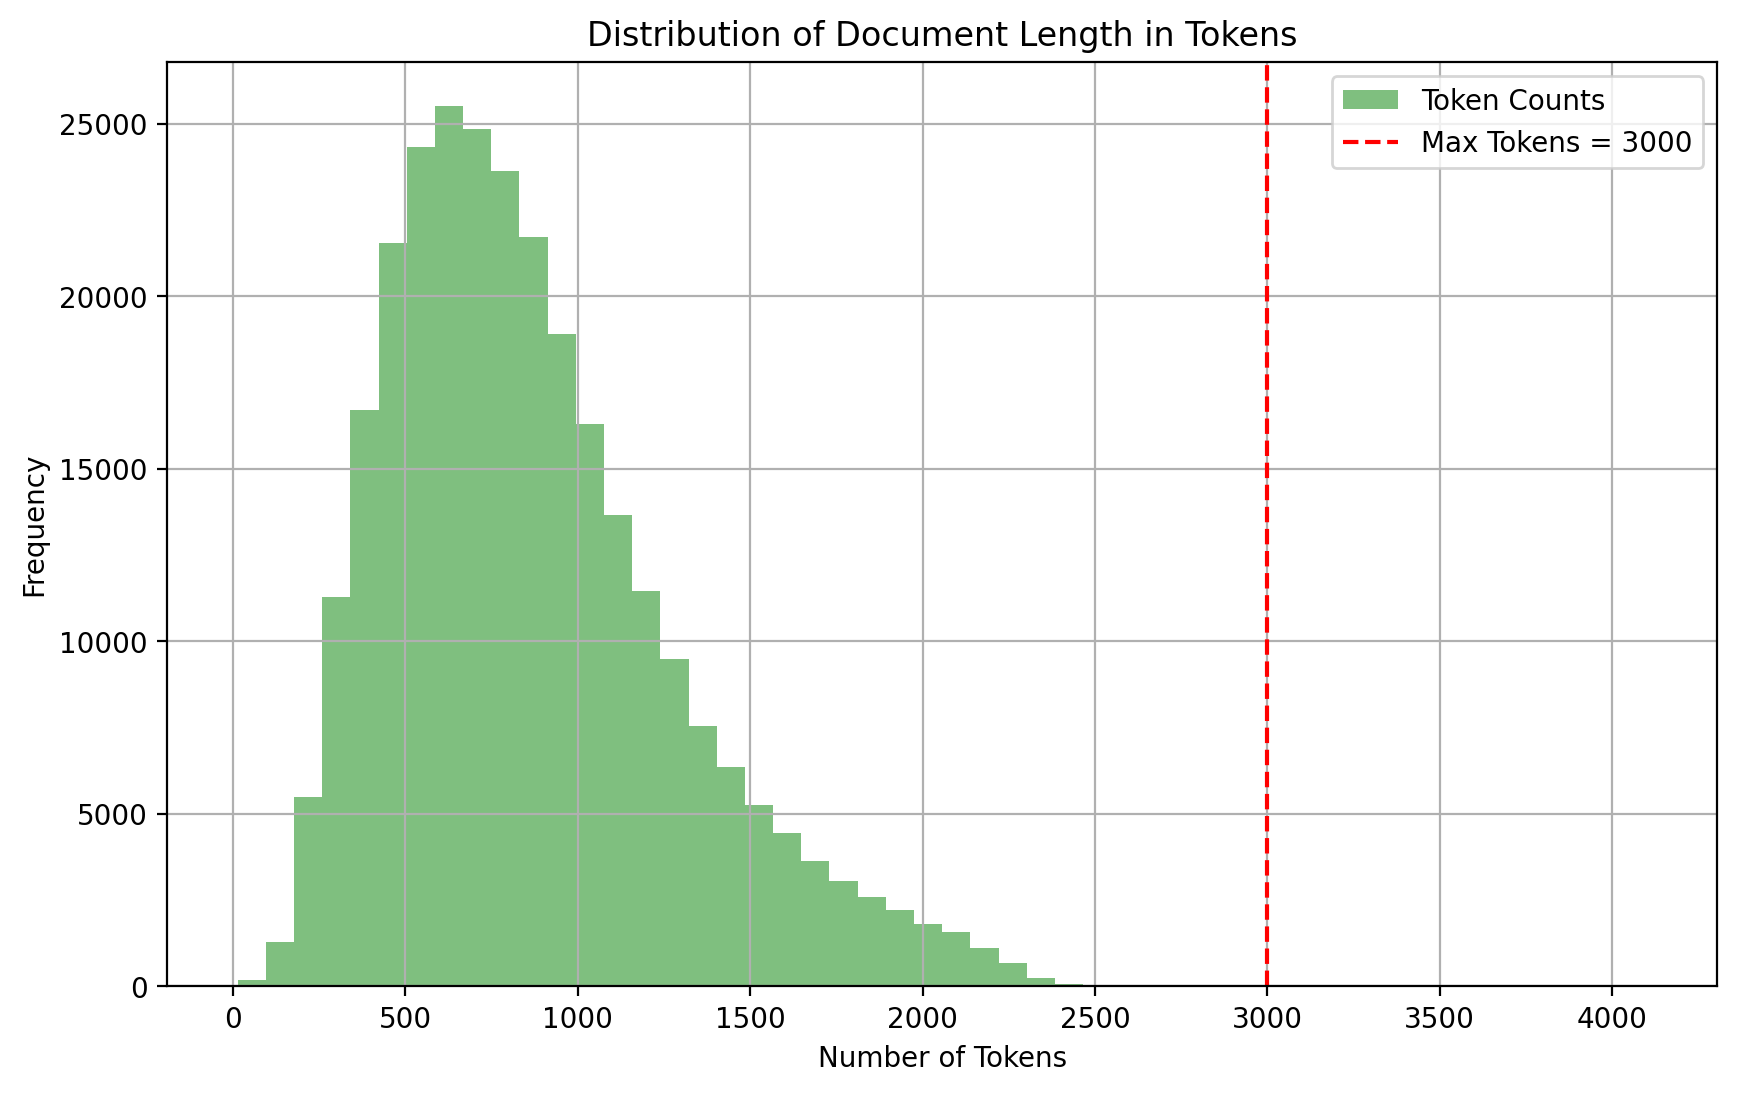

In [7]:
max_input_tokens = 3000 # option to cut input size for more efficient processing

plot_token_counts(df, max_tokens=max_input_tokens)

In [8]:
# drop articles above token limit
df = df[df['tokens'] < max_input_tokens]

# take sample with preference for shorter articles
df = df.sort_values(by='tokens', ascending=True)
weights = 1 / (df['tokens'] + 1)  # Adding 1 to avoid division by zero
normalized_weights = weights / np.sum(weights)

df_sample = df.sample(n=sample_size, replace=False, weights=normalized_weights, random_state=1)

## Generate Summaries and track Content Severity Annotations



In [9]:
# Add columns for summaries and Content Filer annotations
df_sample['summary'] = ""

prompt_severity_cols = ['prompt-hate', 'prompt-sexual', 'prompt-selfharm', 'prompt-violence']
completion_severity_cols = ['compl-hate', 'compl-sexual', 'compl-selfharm', 'compl-violence']
severity_cols = prompt_severity_cols + completion_severity_cols

df_sample = pd.concat([df_sample, pd.DataFrame(columns=severity_cols)])

display(df_sample.head())

,article,tokens,summary,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
160278,"By . Luke Garratt . PUBLISHED: . 11:42 EST, 12...",531.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265907,"(CNN) -- Remember ""You're money, baby""? Vince ...",816.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137538,"Downton Abbey's famously grim butler, Mr Bates .",13.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241090,(CNN) -- The U.N. General Assembly voted to ad...,444.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21119,Tim Sherwood has suggested Tottenham may be re...,319.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
sample = os.path.join(output_folder, 'sample-articles.csv') # reuse for final test

# Save sample to file
df_sample.to_csv(sample, index=False)

In [11]:
def process_df_row(row):
    content = row[content_col]
    result, cf_prompt_results, cf_complletion_results = chat_complete(content)
    
    # extract and transform severity values from the cf_prompt_results and cf_complletion_results
    row['prompt-hate'] = cf_prompt_results['hate']['severity']
    row['prompt-sexual'] = cf_prompt_results['sexual']['severity']
    row['prompt-selfharm'] = cf_prompt_results['self_harm']['severity']
    row['prompt-violence'] = cf_prompt_results['violence']['severity']
    
    row['compl-hate'] = cf_complletion_results['hate']['severity']
    row['compl-sexual'] = cf_complletion_results['sexual']['severity']
    row['compl-selfharm'] = cf_complletion_results['self_harm']['severity']
    row['compl-violence'] = cf_complletion_results['violence']['severity']
    
    row['summary'] = result
    
    return row

# Generate summaries for the whole dataframe. NOTE that this operation incurs Azure OpenAI service charges.

df_sample = df_sample.apply(process_df_row, axis=1)

## Review Severity Annotations
Note that if your content is filtered out due to the prompt (input), then no completions will be provided, and as a result, no corresponding annotations will be generated. In such scenarios, the completion severity categories will be marked as non applicable (n/a).

In [12]:
prompt_severity_cols = ['prompt-hate', 'prompt-sexual', 'prompt-selfharm', 'prompt-violence']
completion_severity_cols = ['compl-hate', 'compl-sexual', 'compl-selfharm', 'compl-violence']
severity_cols = prompt_severity_cols + completion_severity_cols

severities = ['safe', 'low', 'medium', 'high', 'n/a'] # 'n/a' 

# Applying value_counts to each column
value_counts_df = df_sample[severity_cols].apply(lambda col: col.value_counts())

# Reindexing the DataFrame
value_counts_df = value_counts_df.reindex(severities)

# Filling NaN values with 0
value_counts_df = value_counts_df.fillna(0).astype(int)

print('Content severity annotations found in the dataset (prompt) and in the model responses (completions):')
display(value_counts_df)

Content severity annotations found in the dataset (prompt) and in the model responses (completions):


,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
safe,291,292,298,239,256,258,259,249
low,6,3,2,29,4,2,1,8
medium,3,2,0,30,0,0,0,3
high,0,3,0,2,0,0,0,0
n/a,0,0,0,0,40,40,40,40


## Understanding the Impact of Your Content Filter Configuration

You can configure the content filter for user input and model response separately using the following options:

![image-alt-text](./cf-table.png)

Examples:

- Set to low: Filters low, medium and high risk content
- Set to medium: Filters medium and high risk content
- Set to high: Filters high risk content
- Set to off: Switch Content Filter off (approval required)

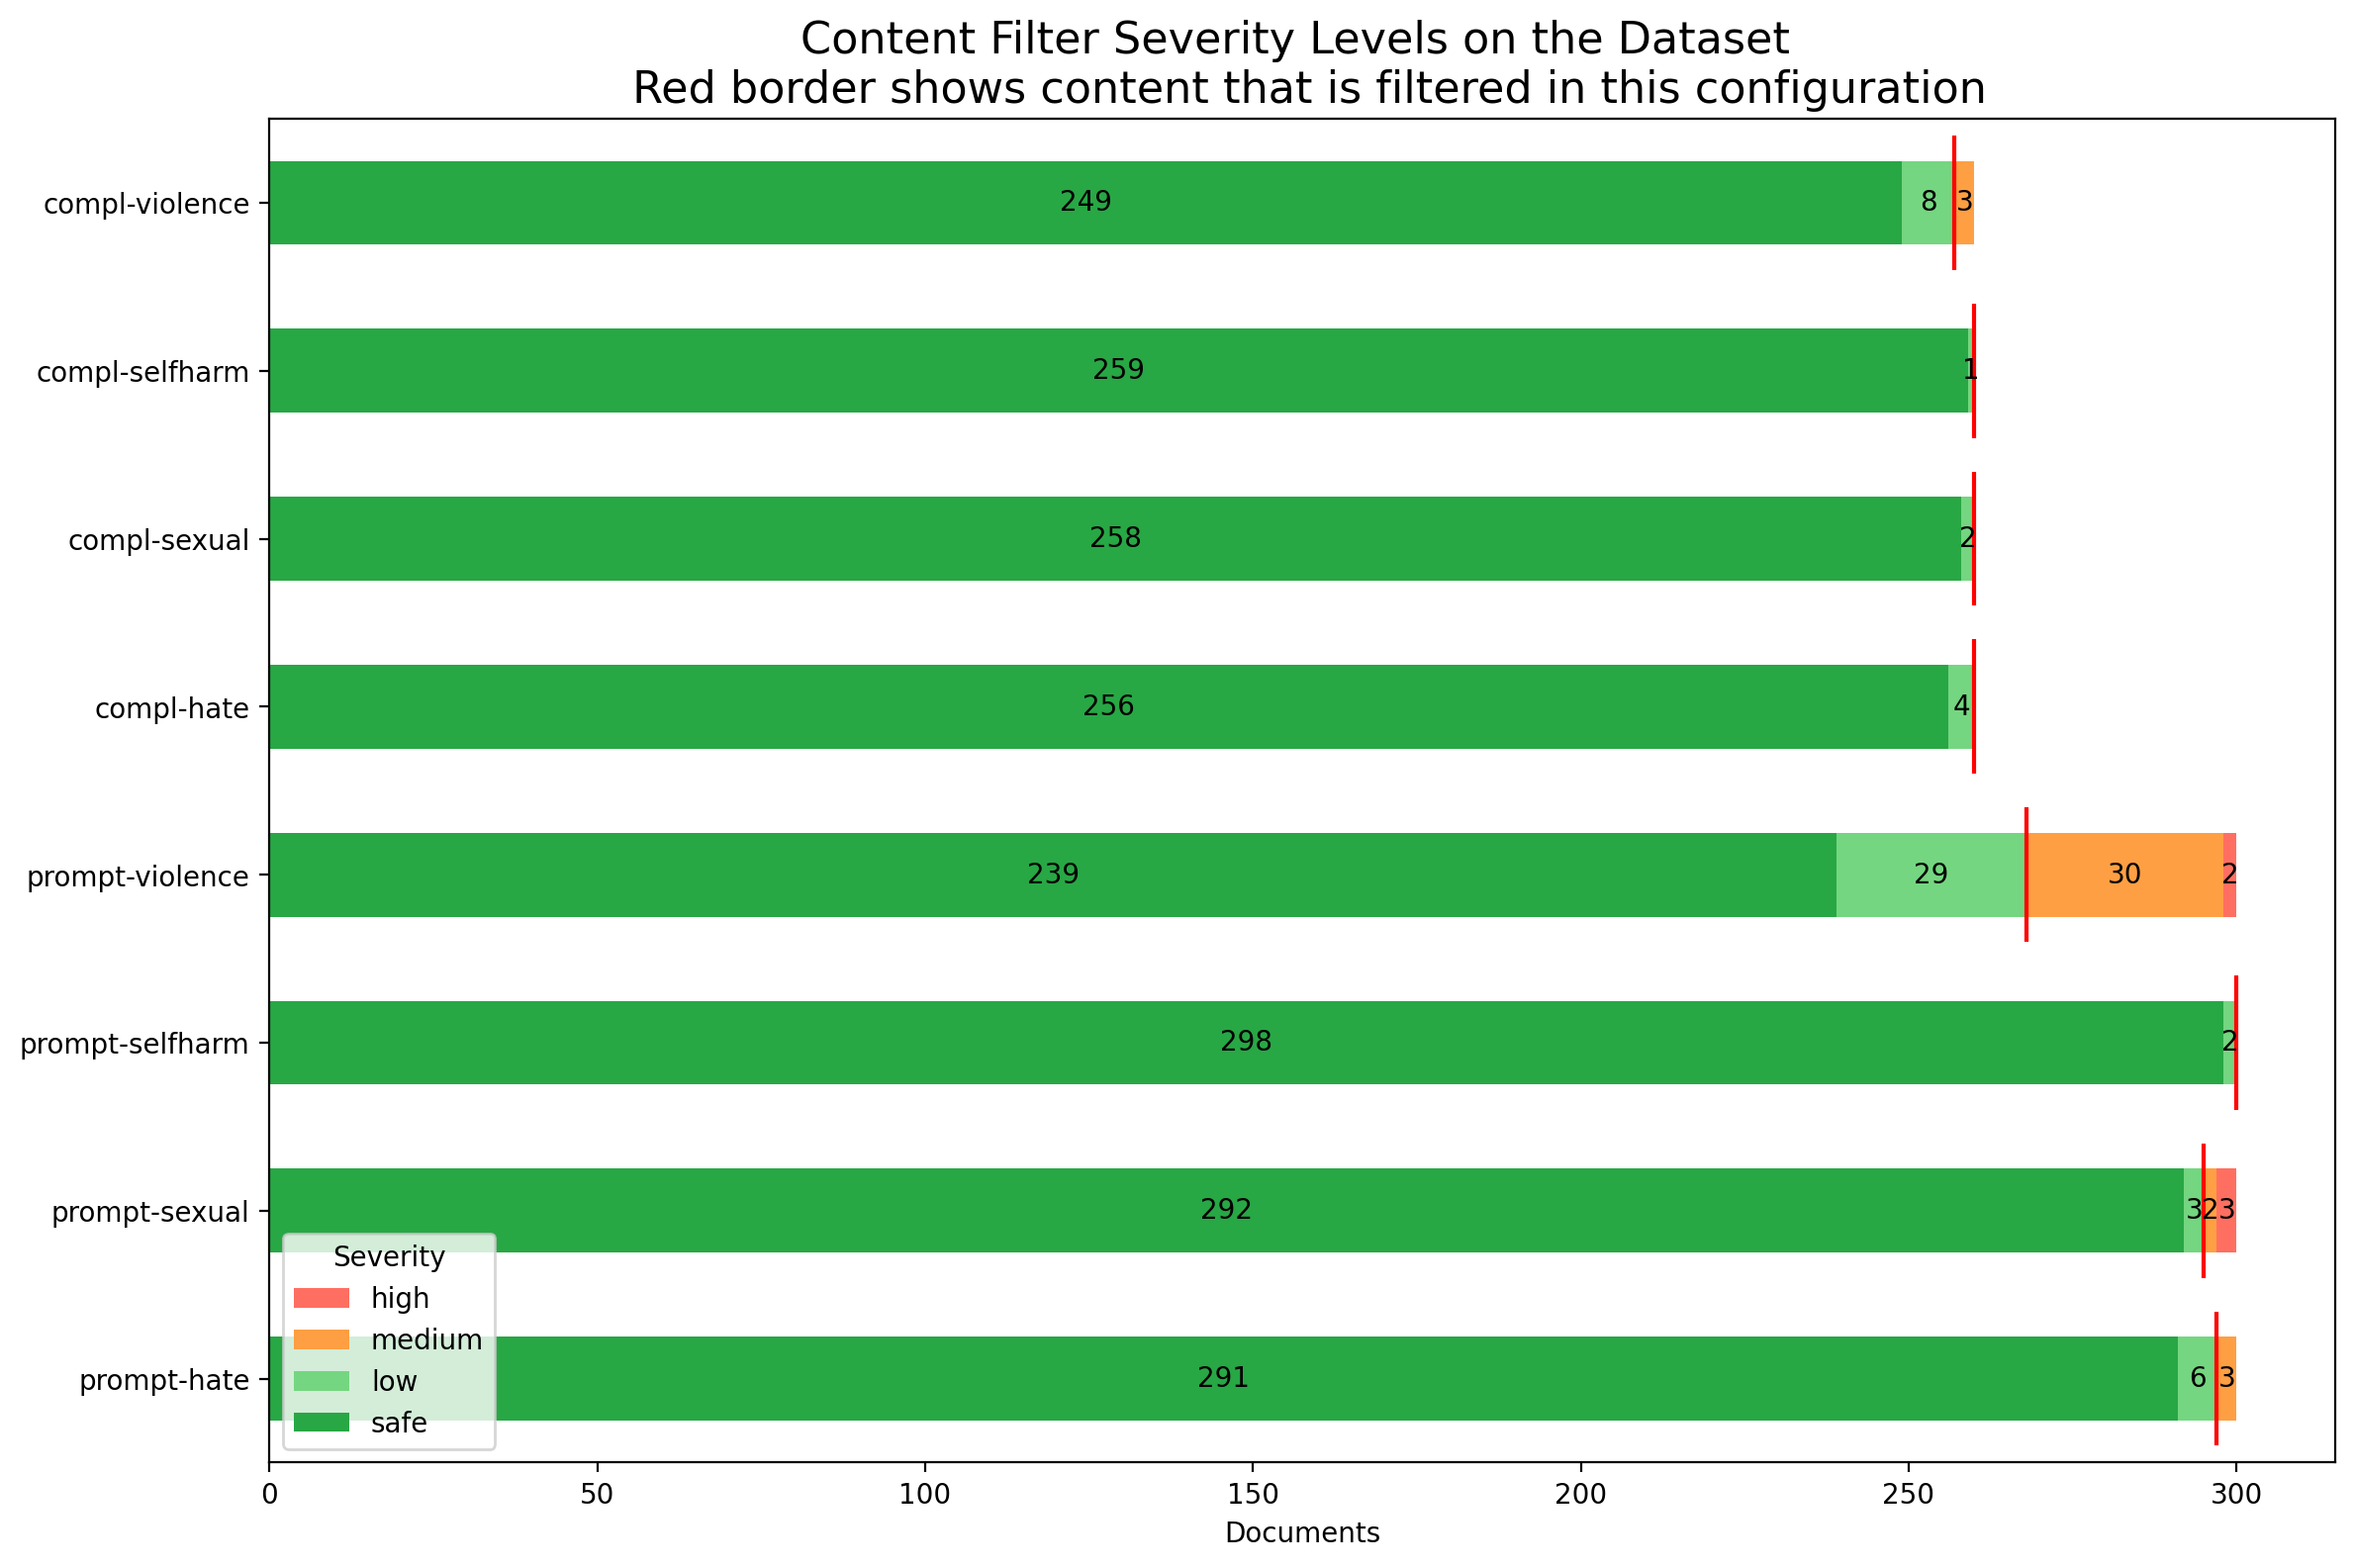

In [13]:
filter_threshold = {
    'prompt-hate' : 'medium',
    'prompt-sexual' : 'medium',
    'prompt-selfharm' : 'medium',
    'prompt-violence' : 'medium',
    'compl-hate' : 'medium',
    'compl-sexual' : 'medium',
    'compl-selfharm' : 'medium',
    'compl-violence' : 'medium',
}

show_statistics(value_counts_df, filter_threshold)

## Review Edge Cases

In [14]:
review_boundary_examples(df_sample, prompt_severity_cols)

### PROMPT-HATE

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

(CNN) -- Brad Paisley has never shied away from controversial topics in his music: Alcohol helps white people dance. Celebrities can act like fools because people think they're cool. Real guys don't get "manicured, waxed and botoxed." But he may have gone a step too far at the Country Music Awards Wednesday night and become one of his own song titles: an "accidental racist." Paisley let viewers know that they wouldn't be seeing the new ABC comedy "Blackâ€¢ish" that evening -- they'd be watching "white-ish." Social media was undecided on whether his dig at country music's predominantly white stars (and predominantly white fan base) was funny or racist. Paisley also "blew it" by announcing the sex of Carrie Underwood's baby on stage, though we're pretty sure that one was planned. If he's to be believed, Underwood and her husband, hockey player Mike Fisher, are having a boy. And the

### PROMPT-SEXUAL

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

(CNN) -- It may have been one of the most eagerly anticipated casting choices of the year, and we now know the leads in the film adaptation of "Fifty Shades of Grey." The novel's author, E.L. James, tweeted on Monday that actor Charlie Hunnam will portray Christian Grey, and actress Dakota Johnson has been cast as Anastasia Steele. The highly successful erotic novel was released in 2011, and fans have been speculating about who might portray the two main characters since plans for a film were announced last year. A psychology lecturer at the University of Central Lancashire even put a face to the character of billionaire Grey, who has had readers all aflame. Now, the fantasy will come to life in the form of Hunnam, who is one of the stars of the film "Pacific Rim" and the television series "Sons of Anarchy." Johnson is the daughter of actors Melanie Griffith and Don Johnson and h

### PROMPT-SELFHARM

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

(CNN) -- A Las Vegas cabbie had no second thoughts when he found $300,000 in cash in a brown paper bag in his cab this week. He made sure it was returned to the forgetful owner. "I don't care from $10 to higher. My dignity is not for sale, and that's the way I am. That's the way our parents taught us when I was a kid," cabbie Gerardo Gamboa told CNN affiliate KVVU. "All I wanted to do was just call my dispatcher and return it, and this is the only chance I have to show cab drivers in Las Vegas are not bad people." The loser of the money -- at least temporarily, thanks to Gamboa's good deed -- was a famous 28-year-old professional poker player, whom officials weren't publicly identifying, according to another CNN affiliate, KLAS. The gambler was so devastated at his loss Monday that "he wanted to shoot himself in the head," a cab company official told KLAS. "He was grateful. He wa

### PROMPT-VIOLENCE

Example document classified as LOW severity which is considered ACCEPTABLE in the simulated configuration:

PUBLISHED: . 07:30 EST, 9 July 2013 . | . UPDATED: . 10:41 EST, 9 July 2013 . Fifty-three people have been wounded in a car bomb in a Hezbollah stronghold in Beirut as Britain announces £50m aid to help Syrian refugees in Lebanon. The blast occurred this morning in the area dominated by the  Lebanese Shi'ite Hezbollah militant group that has been fighting in Syria's civil war, security sources said. The sources were unable to confirm initial reports from medics at the scene that an unspecified number were killed in the massive blast. Scroll down for video . Blast: Eighteen people have been wounded in a car bomb in a Hezbollah stronghold in Beirut, Lebanon . Destruction: The blast occurred this morning in the south suburbs which are dominated by the Lebanese Shi'ite Hezbollah militant group that has been fighting in Syria's civil war, security sources said . Target:: The blast was

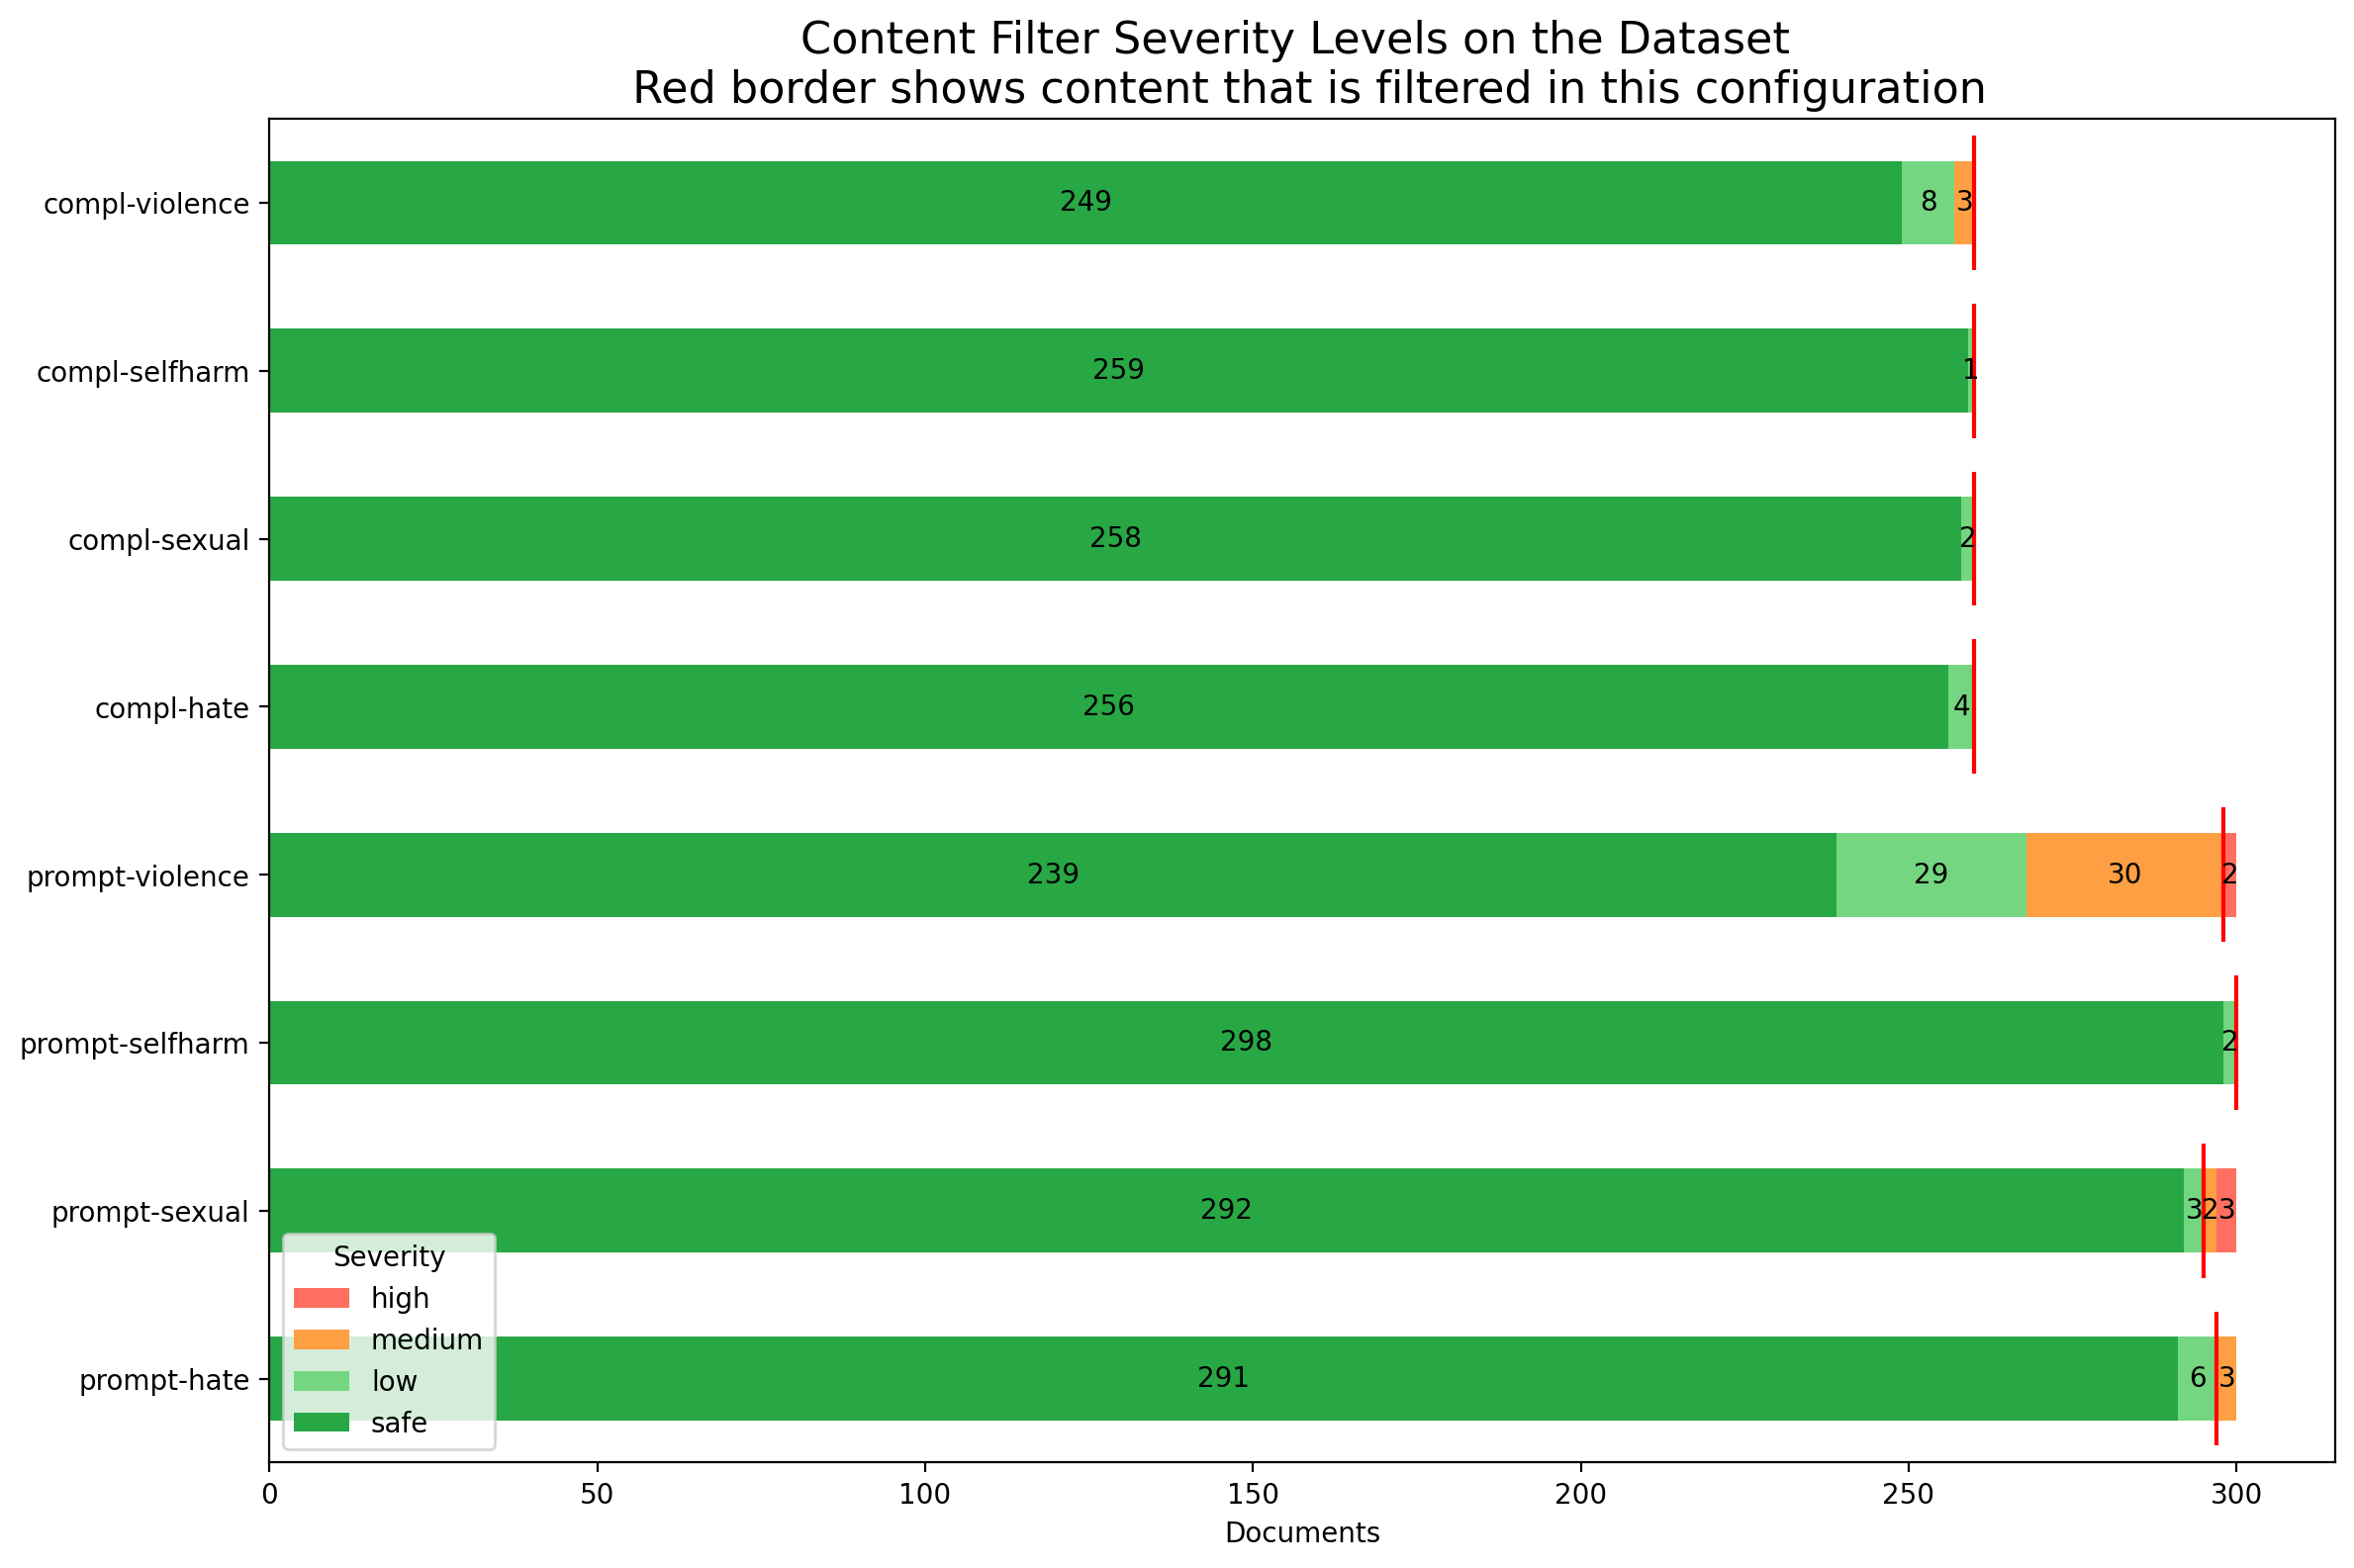

In [15]:
# Specify your configuration to review the impact:

adjusted_filter_threshold = {
    'prompt-hate' : 'medium',
    'prompt-sexual' : 'medium',
    'prompt-selfharm' : 'medium',
    'prompt-violence' : 'high',
    'compl-hate' : 'medium',
    'compl-sexual' : 'medium',
    'compl-selfharm' : 'medium',
    'compl-violence' : 'high',
}

show_statistics(value_counts_df, adjusted_filter_threshold)

## Adjusting the Content Filter in the Azure AI Studio
Now that we have found our target settings, we are adjusting the Content Filter that is associated with the deployed model in the [Azure AI Studio](https://ai.azure.com/) accordingly.
The settings that we have identified above correspond with the configuration in the screenshot from the Azure AI Studio.
![image-alt-text](./content-filter-news-ai-studio.png)


## Alternative: Adjust the Content Filter using the Azure AI Management API
Instead of manually specifying Content Filter details in the Azure AI Studio, we can also use the Azure AI Management API to configure it programmatically.  
Check out the API [RAI Policies documentation](https://learn.microsoft.com/en-us/rest/api/aiservices/accountmanagement/rai-policies?view=rest-aiservices-accountmanagement-2023-10-01-preview) for more details.
For the notebook, we have created the `AOAIContentFilterManager()` class which lets you query and specify Content Filter details easily.

In [16]:
# instantiate the Content FIlter manager
cf_manager = AOAIContentFilterManager(subscription_id, resource_group_name, account_name)

# list all filters in the AOAI resource
my_filters = cf_manager.list_content_filters()
print(my_filters)

['energy', 'HERA', 'no-filter', 'guided-content-gen', 'myfilter', 'prompt-shield', 'news', 'Microsoft.Default', 'Microsoft.DefaultV2']


In [17]:
# show details of current content filter
current_policy = cf_manager.get_filter_details('news')
pprint.pprint(current_policy['properties']['contentFilters'], width=120, compact=True)

[{'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'hate', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'sexual', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'selfharm', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'violence', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'hate', 'source': 'Completion'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'sexual', 'source': 'Completion'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'selfharm', 'source': 'Completion'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'violence', 'source': 'Completion'}]


In [18]:
# reconfigure filter according to simulated thresholds
target_policy = create_adjusted_policy_data(adjusted_filter_threshold)
updated_filter = cf_manager.create_or_update_filter("news", target_policy)
pprint.pprint(target_policy['properties']['contentFilters'], width=120, compact=True)

[{'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'hate', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'sexual', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'selfharm', 'source': 'Prompt'},
 {'allowedContentLevel': 'High', 'blocking': True, 'enabled': True, 'name': 'violence', 'source': 'Prompt'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'hate', 'source': 'Completion'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'sexual', 'source': 'Completion'},
 {'allowedContentLevel': 'Medium', 'blocking': True, 'enabled': True, 'name': 'selfharm', 'source': 'Completion'},
 {'allowedContentLevel': 'High', 'blocking': True, 'enabled': True, 'name': 'violence', 'source': 'Completion'}]


## Generate final Results

In [19]:
# Reload previous version
df_sample_final = pd.read_csv(sample)
df_sample_final.head()

# Clear previously generated summaries and severity annotations
# df_sample_final[severity_cols] = df_sample_final[severity_cols].apply(lambda x: pd.NA)
# df_sample_final['summary'] = ''

,article,tokens,summary,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
0,"By . Luke Garratt . PUBLISHED: . 11:42 EST, 12...",531.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"(CNN) -- Remember ""You're money, baby""? Vince ...",816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Downton Abbey's famously grim butler, Mr Bates .",13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,(CNN) -- The U.N. General Assembly voted to ad...,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tim Sherwood has suggested Tottenham may be re...,319.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Generate final summaries for the whole dataframe. NOTE that this operation incurs Azure OpenAI service charges.

df_sample_final = df_sample_final.apply(process_df_row, axis=1)

In [21]:
# Save final results to file
final_sample = os.path.join(output_folder, 'sample-final-with-annotations.csv')
df_sample_final.to_csv(final_sample, index=False)

In [22]:
# Applying value_counts to each column
value_counts_df = df_sample_final[severity_cols].apply(lambda col: col.value_counts())

# Reindexing the DataFrame
value_counts_df = value_counts_df.reindex(severities)

# Filling NaN values with 0
value_counts_df = value_counts_df.fillna(0).astype(int)

print('Content severity annotations found in the dataset (prompt) and in the model responses (completions):')
display(value_counts_df)

Content severity annotations found in the dataset (prompt) and in the model responses (completions):


,prompt-hate,prompt-sexual,prompt-selfharm,prompt-violence,compl-hate,compl-sexual,compl-selfharm,compl-violence
safe,291,292,298,239,288,285,289,264
low,6,3,2,29,2,4,1,16
medium,3,2,0,30,0,1,0,10
high,0,3,0,2,0,0,0,0
n/a,0,0,0,0,10,10,10,10


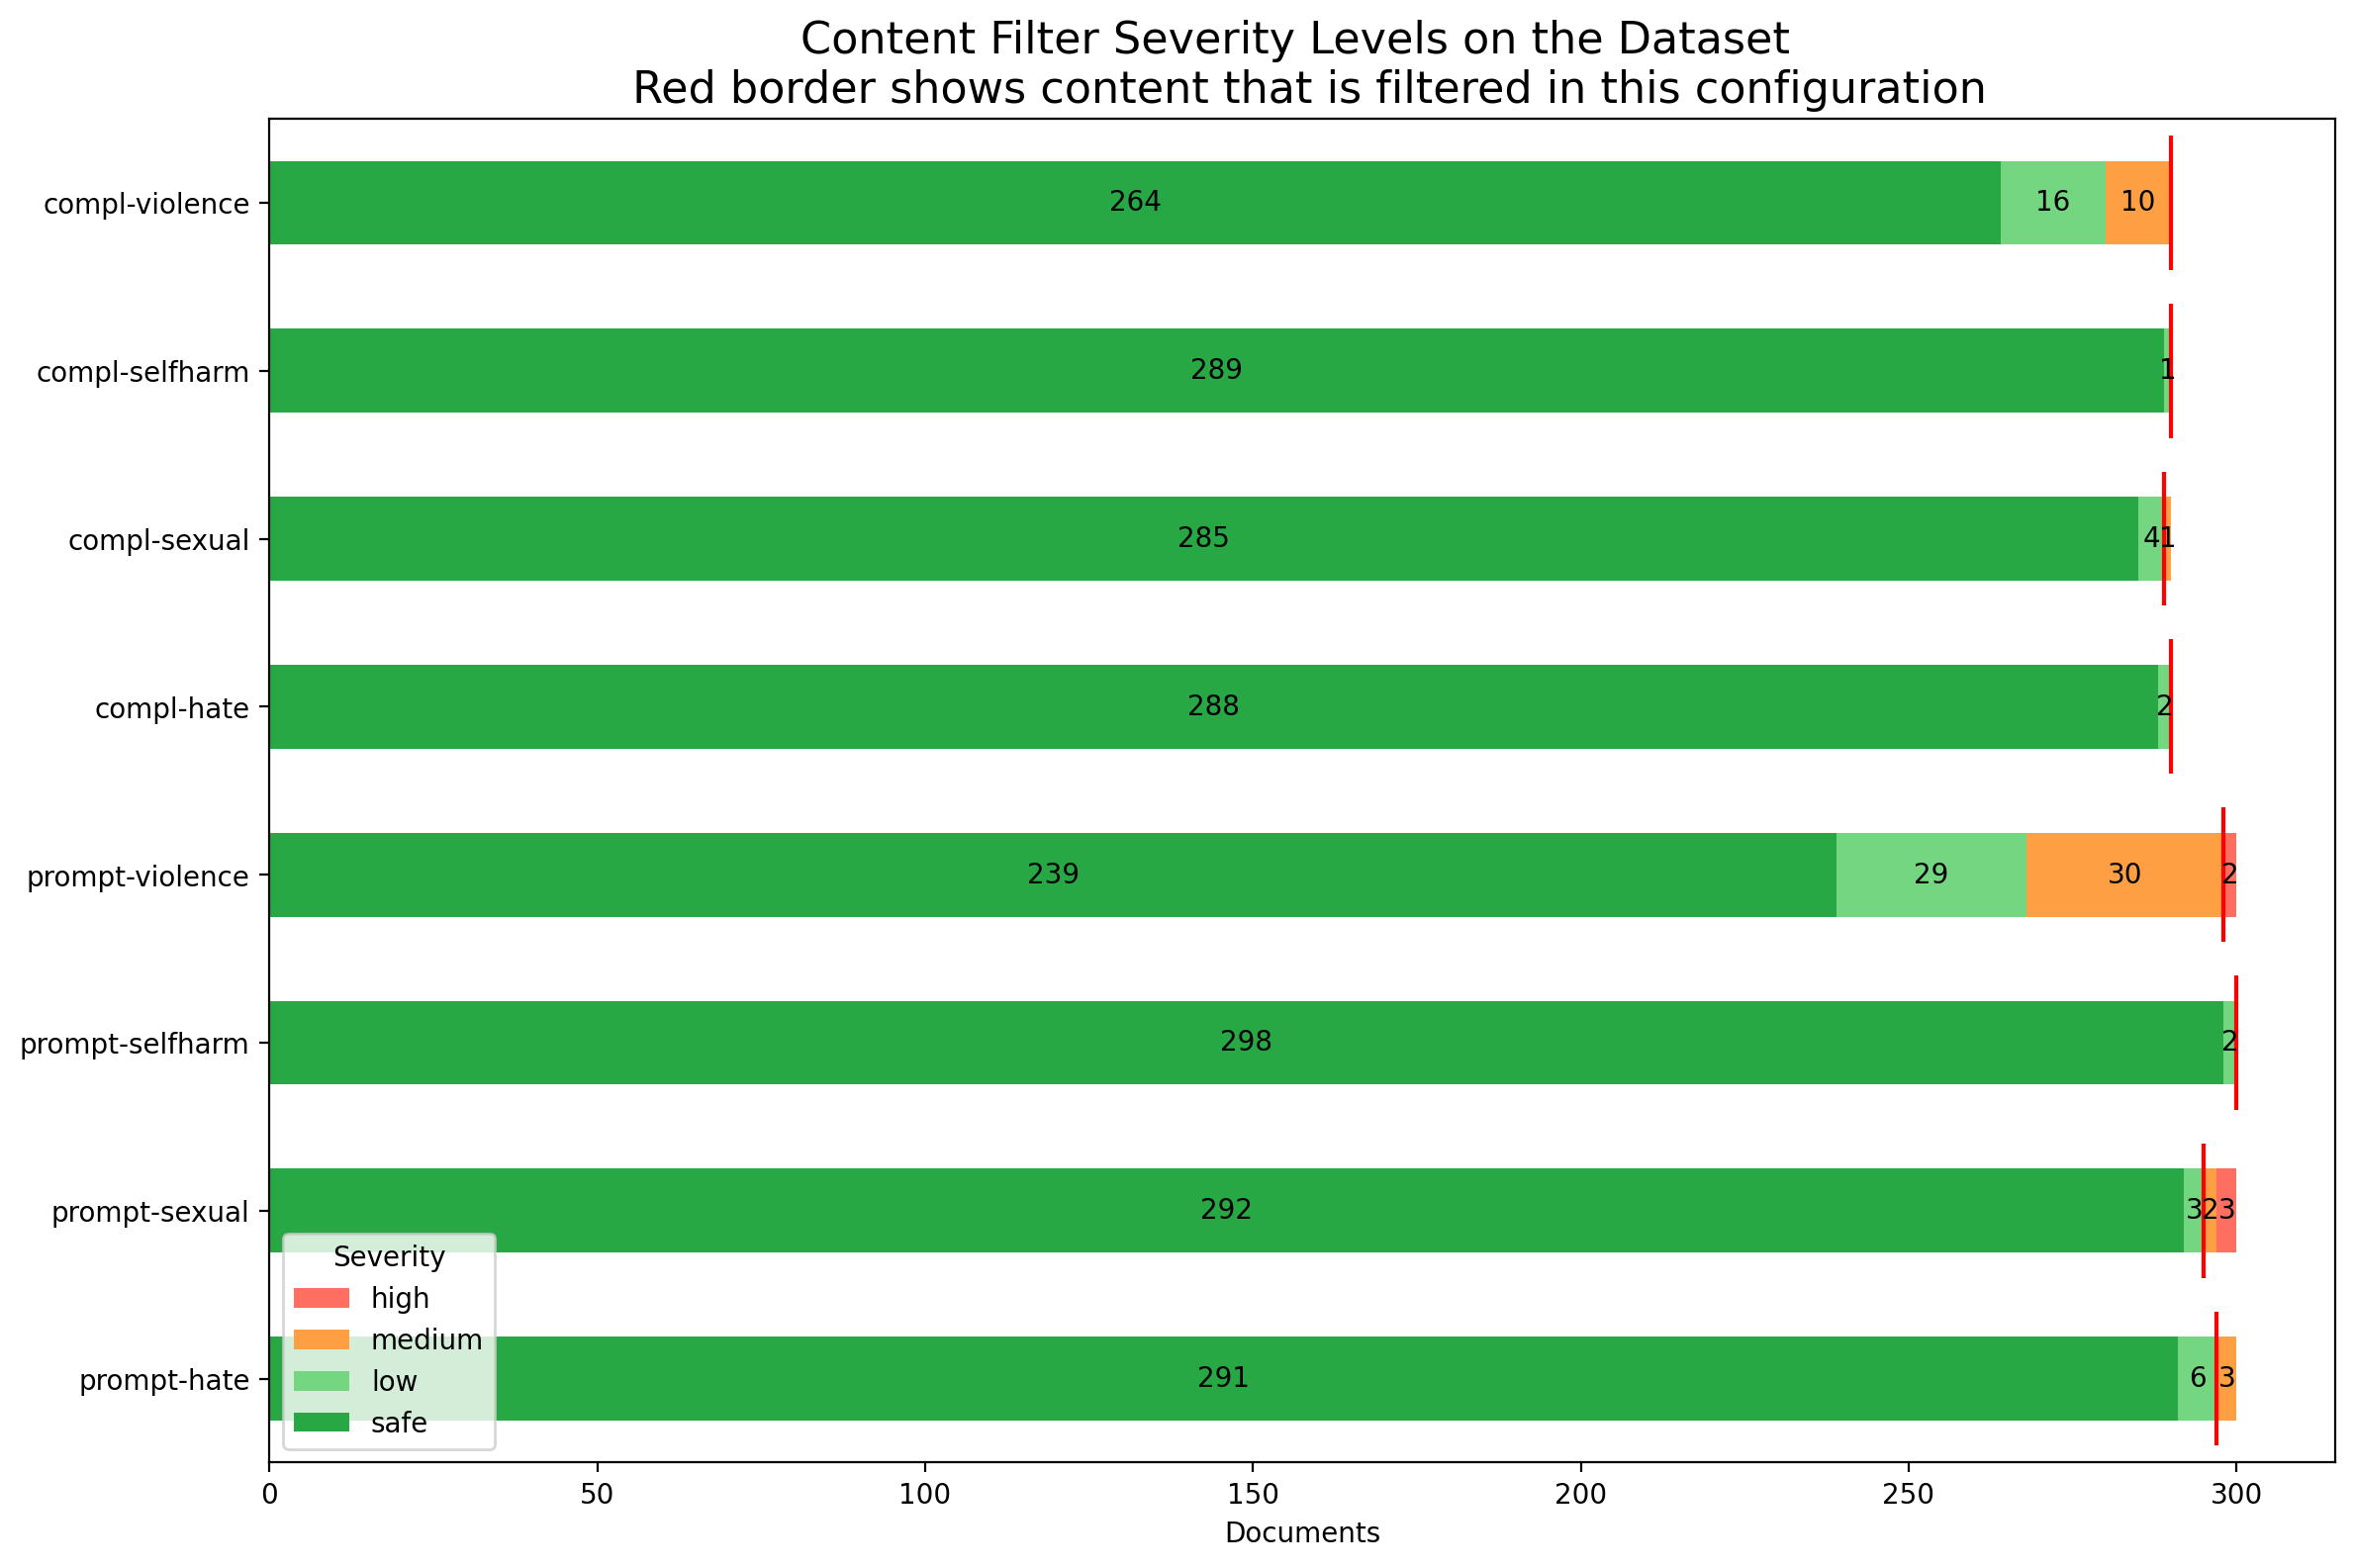

In [23]:
show_statistics(value_counts_df, adjusted_filter_threshold)